In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential, model_from_json
from keras.layers import Embedding,Bidirectional,Dense,Conv1D,Flatten,LSTM,GRU,GlobalMaxPooling1D,MaxPooling1D,Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import h5py

Using TensorFlow backend.


In [3]:
os.chdir('drive/My Drive/IMDB Sentiment Analysis/')

In [4]:
# Reading test, train, and, validation set
 
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
validation = pd.read_csv('Valid.csv')
dataframeIMBD = pd.concat([train, validation, test], axis=0)

In [5]:
dataframeIMBD.shape

(50000, 2)

In [13]:
dataframeIMBD[dataframeIMBD.label==0].count()
#Equally balanced dataset

text     25000
label    25000
dtype: int64

In [8]:
sentences=dataframeIMBD['text']
sentences

0       I grew up (b. 1965) watching and loving the Th...
1       When I put this movie in my DVD player, and sa...
2       Why do people who do not know what a particula...
3       Even though I have great interest in Biblical ...
4       Im a die hard Dads Army fan and nothing will e...
                              ...                        
4995    This is the kind of picture John Lassiter woul...
4996    A MUST SEE! I saw WHIPPED at a press screening...
4997    NBC should be ashamed. I wouldn't allow my chi...
4998    This movie is a clumsy mishmash of various gho...
4999    Formula movie about the illegitimate son of a ...
Name: text, Length: 50000, dtype: object

In [9]:
Y=dataframeIMBD['label']

In [10]:
tokenizer = Tokenizer(num_words = 4000)
tokenizer.fit_on_texts(sentences)     #Updates internal vocabulary based on a list of texts.
sequence = tokenizer.texts_to_sequences(sentences) #Transforms each text in texts to a sequence of integers.

In [11]:
index_of_words = tokenizer.word_index
print(len(index_of_words))

124252


In [12]:
list(index_of_words.items())[:10]

[('the', 1),
 ('and', 2),
 ('a', 3),
 ('of', 4),
 ('to', 5),
 ('is', 6),
 ('br', 7),
 ('in', 8),
 ('it', 9),
 ('i', 10)]

In [13]:
max_seq_len=1000
padded_seq = pad_sequences(sequence , maxlen = max_seq_len, padding='pre', truncating='post', value=0.0 )

In [14]:
padded_seq

array([[   0,    0,    0, ...,    3,  642,    4],
       [   0,    0,    0, ...,   38,   20,  240],
       [   0,    0,    0, ...,    1,   19, 2261],
       ...,
       [   0,    0,    0, ...,  397,   38, 1033],
       [   0,    0,    0, ...,  867,  867,  867],
       [   0,    0,    0, ...,   23, 1267, 2615]], dtype=int32)

In [15]:

from keras.utils import to_categorical

#Y = to_categorical(Y)

In [16]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(padded_seq,Y ,train_size = 0.7)

In [17]:
Y_train.shape

(35000,)

In [18]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [19]:
f = open('glove.6B.100d.txt')
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 400000 word vectors.


In [20]:
embedd_index['awesome']

array([-0.18008  ,  0.084106 ,  0.72864  , -0.77307  , -0.60034  ,
       -0.19223  , -0.22914  ,  0.42666  , -0.12717  , -0.0065352,
        0.83655  , -0.065268 , -0.16575  , -0.88205  ,  0.1876   ,
        0.076791 , -0.27967  ,  0.91433  , -0.39398  ,  0.66955  ,
        0.54149  ,  0.32752  , -0.094895 , -0.51644  ,  0.90136  ,
        0.54181  ,  0.26746  ,  0.68016  ,  0.22842  , -0.73537  ,
       -0.20871  , -0.059895 ,  0.24477  , -0.037463 ,  0.068086 ,
       -0.42048  , -0.94419  ,  0.34877  ,  0.11188  , -0.52052  ,
        0.53379  ,  0.82981  ,  0.36603  , -0.095496 , -0.05701  ,
        0.61821  ,  0.58893  , -0.025414 ,  0.038517 , -0.64536  ,
       -0.32316  , -0.13728  ,  0.73336  ,  0.16069  ,  0.1331   ,
       -1.1587   ,  0.82379  ,  0.47982  ,  0.25612  , -0.095601 ,
        0.21236  ,  0.48335  , -0.57491  ,  0.12975  ,  0.3161   ,
       -0.078513 ,  0.33765  , -0.28684  , -0.15185  ,  0.14687  ,
        0.68358  , -0.30267  , -0.13771  ,  0.06876  ,  0.3115

In [21]:
embed_num_dims = 100 #for 100 dimensional word vector

embedding_matrix = np.zeros((len(index_of_words) + 1, embed_num_dims))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
#for plotting
        tokens.append(embedding_matrix[i])
        labels.append(word)


In [22]:
embedding_matrix.shape

(124253, 100)

(200, 2)


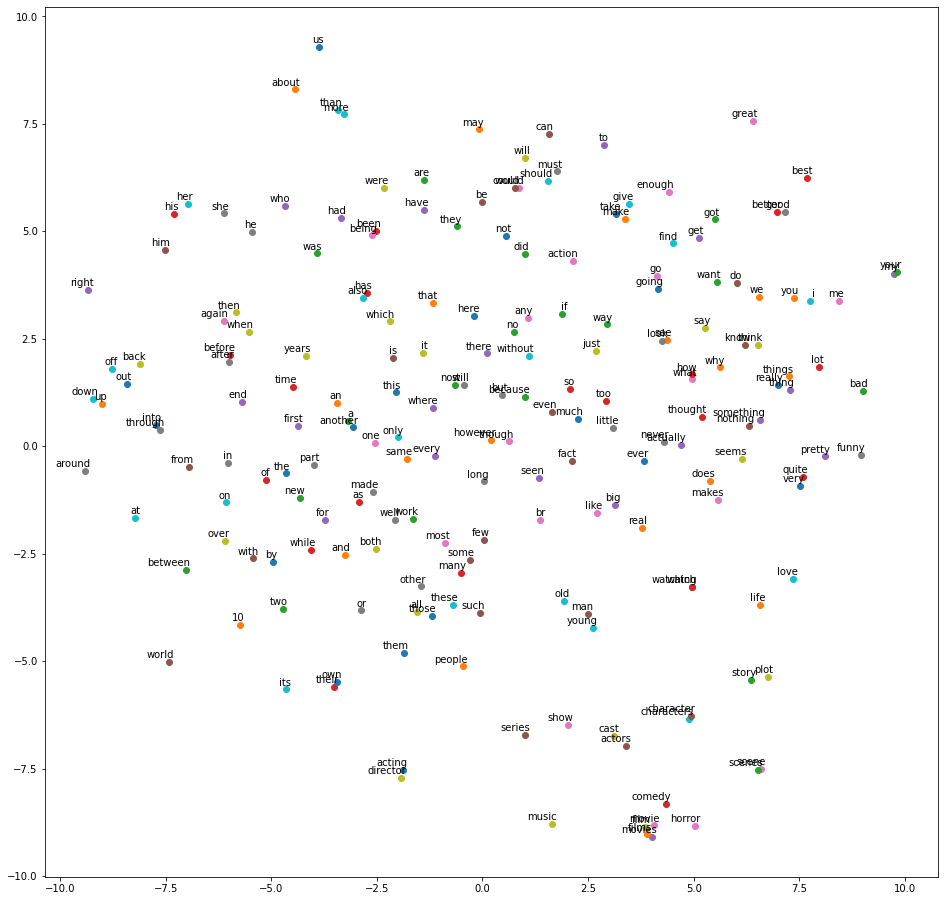

In [23]:
#TSNE algorithm used to visualize word embeddings having huge amount (100) dimensions

def tsne():
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:200])
    print(new_values.shape)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16,16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig('word_vectors.png')
    plt.show()
    
        
tsne()


In [24]:
#Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(len(index_of_words) + 1 , embed_num_dims , input_length = max_seq_len , weights = [embedding_matrix])

#LSTM

**dropout VS recurrent_dropout**

Regular dropout is applied on the inputs and/or the outputs, meaning the vertical arrows from x_t and to h_t. If you add it as an argument to your layer, it will mask the inputs; you can add a Dropout layer after your recurrent layer to mask the outputs as well. Recurrent dropout masks (or "drops") the connections between the recurrent units; that would be the horizontal arrows in your picture.

In [84]:
model = Sequential()
model.add(embedd_layer)
model.add(Bidirectional(LSTM(30 , return_sequences = True , dropout = 0.1 , recurrent_dropout = 0.1)))
model.add(GlobalMaxPooling1D())  #from 2D to 1D
model.add(Dense(30,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2,activation = 'sigmoid'))

In [85]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         12425300  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 60)          31440     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1830      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 62        
Total params: 12,458,632
Trainable params: 12,458,632
Non-trainable params: 0
__________________________________________

In [86]:
from keras.models import model_from_json
def load():
    load_json = open("weights.json",'r')
    loaded = load_json.read()
    load_json.close()
    load = model_from_json(loaded)
    load.load_weights("model.h5")
    print("Loaded")
    model = load

In [87]:
from keras.optimizers import Adam
add = Adam(lr = 0.01)
model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = add , metrics = ['accuracy'])

In [88]:
hist = model.fit(X_train,Y_train,epochs = 10 , batch_size = 512, validation_data = (X_test,Y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 602s 17ms/step - loss: 0.3329 - accuracy: 0.8512 - val_loss: 0.2617 - val_accuracy: 0.8946
Epoch 2/10
35000/35000 [==============================] - 600s 17ms/step - loss: 0.2037 - accuracy: 0.9248 - val_loss: 0.2509 - val_accuracy: 0.9008
Epoch 3/10
35000/35000 [==============================] - 593s 17ms/step - loss: 0.1509 - accuracy: 0.9491 - val_loss: 0.2592 - val_accuracy: 0.9040
Epoch 4/10
35000/35000 [==============================] - 592s 17ms/step - loss: 0.1240 - accuracy: 0.9593 - val_loss: 0.2964 - val_accuracy: 0.8947
Epoch 5/10
35000/35000 [==============================] - 593s 17ms/step - loss: 0.1023 - accuracy: 0.9663 - val_loss: 0.3095 - val_accuracy: 0.9026
Epoch 6/10
35000/35000 [==============================] - 596s 17ms/step - loss: 0.0867 - accuracy: 0.9729 - val_loss: 0.3317 - val_accuracy: 0.9030
Epoch 7/10
35000/35000 [==============================] 

In [91]:
#Saving model

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


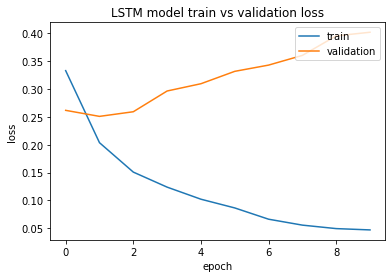

In [118]:
# plot train and validation loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('LSTM model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('LSTM_loss.png')
plt.show()

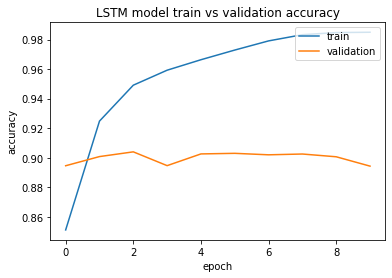

In [119]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('LSTM model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('LSTM_accuracy.png')
plt.show()

In [92]:
result = model.evaluate(X_test,Y_test)

15000/15000 [==============================] - 90s 6ms/step


In [93]:
print(result[1]*100)

89.43333625793457


In [94]:
Y_pred = model.predict_classes(X_test,batch_size = 512)
matrix = confusion_matrix(Y_test, Y_pred)
matrix

array([[7038,  553],
       [1032, 6377]])

In [95]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7591
           1       0.92      0.86      0.89      7409

    accuracy                           0.89     15000
   macro avg       0.90      0.89      0.89     15000
weighted avg       0.90      0.89      0.89     15000



In [47]:
# To reload trained model

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test,Y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 96.37%


#CNN

In [72]:
model_conv = Sequential()
model_conv.add(embedd_layer)
model_conv.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_conv.add(MaxPooling1D(pool_size=2))
model_conv.add(LSTM(100))
model_conv.add(Dense(1, activation='sigmoid'))

In [73]:
add=Adam(learning_rate=0.01)
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_conv.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         12425300  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 32)          9632      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 12,488,233
Trainable params: 12,488,233
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
hist_conv=model_conv.fit(X_train, Y_train, epochs=10, batch_size=64, validation_data = (X_test,Y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 626s 18ms/step - loss: 0.2842 - accuracy: 0.8797 - val_loss: 0.2590 - val_accuracy: 0.8963
Epoch 2/10
35000/35000 [==============================] - 624s 18ms/step - loss: 0.2038 - accuracy: 0.9219 - val_loss: 0.2629 - val_accuracy: 0.8903
Epoch 3/10
35000/35000 [==============================] - 621s 18ms/step - loss: 0.1830 - accuracy: 0.9315 - val_loss: 0.2831 - val_accuracy: 0.8828
Epoch 4/10
35000/35000 [==============================] - 622s 18ms/step - loss: 0.1619 - accuracy: 0.9396 - val_loss: 0.2764 - val_accuracy: 0.9033
Epoch 5/10
35000/35000 [==============================] - 629s 18ms/step - loss: 0.1350 - accuracy: 0.9527 - val_loss: 0.2714 - val_accuracy: 0.9023
Epoch 6/10
35000/35000 [==============================] - 619s 18ms/step - loss: 0.1110 - accuracy: 0.9625 - val_loss: 0.2887 - val_accuracy: 0.9008
Epoch 7/10
35000/35000 [==============================] 

In [75]:
#Saving Conv model
# Serialize model to JSON
model_json_conv = model_conv.to_json()
with open("model_conv.json", "w") as json_file:
    json_file.write(model_json_conv)
# serialize weights to HDF5
model_conv.save_weights("model_conv.h5")
print("Saved model to disk")

Saved model to disk


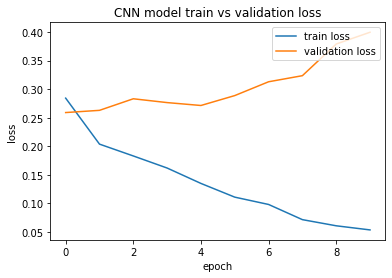

In [121]:
# plot train and validation loss
plt.plot(hist_conv.history['loss'])
plt.plot(hist_conv.history['val_loss'])
plt.title('CNN model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper right')
plt.savefig('CNN_loss.png')
plt.show()

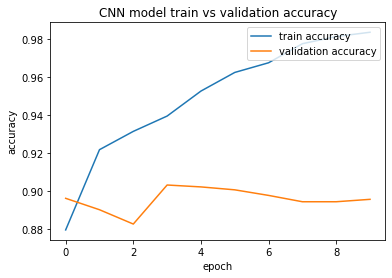

In [120]:
plt.plot(hist_conv.history['accuracy'])
plt.plot(hist_conv.history['val_accuracy'])
plt.title('CNN model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='upper right')
plt.savefig('CNN_accuracy.png')
plt.show()

In [81]:
# Final evaluation of the model
scores = model_conv.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 89.58%


In [82]:
Y_pred = model_conv.predict_classes(X_test,batch_size = 64)
matrix = confusion_matrix(Y_test, Y_pred)
matrix

array([[6793,  798],
       [ 765, 6644]])

In [83]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7591
           1       0.89      0.90      0.89      7409

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



In [ ]:
# To reload trained model
# load json and create model
json_file = open('model_conv.json', 'r')
loaded_model_conv_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_conv_json)

# load weights into new model
loaded_model.load_weights("model_conv.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(X_test,Y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

#GRU

In [126]:
model_GRU = Sequential()
model_GRU.add(embedd_layer)
model_GRU.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))
model_GRU.add(Dense(32))
model_GRU.add(Dense(1, activation='sigmoid'))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         12425300  
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 66        
Total params: 12,439,190
Trainable params: 12,439,190
Non-trainable params: 0
_________________________________________________________________


In [ ]:
add=Adam(learning_rate=0.01)
model_GRU.compile(loss='binary_crossentropy', optimizer=add, metrics=['accuracy'])
model_GRU.summary()

In [127]:
model_GRU.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=128, verbose=1)

ValueError: ignored

In [ ]:
Y_pred = model.predict_classes(X_test,batch_size = 500)
confusion_matrix(Y_test, Y_pred)

In [ ]:
print(classification_report(Y_test, Y_pred))